In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from tqdm import tqdm

In [39]:
class SinteticDataset(torch.utils.data.Dataset):
    def __init__(self, directory, subwindow=None,
                 transform=None, D=1, skip=1):
        # D - Number of datas to retrieve. 
        # skip - interval between observations
        # skip = 1 we get every observation
        # skip = 2 every other observation

        self.directory = directory
        self.subwindow = subwindow  # Proportion of subwindow
        self.files = [f for f in os.listdir(directory) if '.npy' in f] #All available files
        self.D = D
        self.skip = skip
        self.Nx = (40*2)*2
        self.Ny = (68*2)*2
        self.valid_index = self.calcular_indices_validos()


    def __len__(self):
        return len(self.valid_index)

    def __getitem__(self, idx, subwindow=None):
        idx = self.valid_index[idx]
        file = idx//150
        data = np.load(self.directory + "/" + self.files[file])
        if file>0:
            idx = idx-file*150
        psi1 = data[0:150]
        psi2 = data[150:]
        psi1 = data[idx: idx + self.D*self.skip: self.skip]
        psi2 = data[idx: idx + self.D*self.skip: self.skip]
        if subwindow is None:
            subwindow = self.subwindow

        Ny_mesh, Nx_mesh = torch.meshgrid(torch.arange(self.Ny),torch.arange(self.Nx))
        lat_idx, lon_idx = self.get_indices_from_proportion(Ny_mesh, Nx_mesh, subwindow)
        # if subwindow == None
        # len(Ny_mesh) == Ny
        # len(Nx_mesh) == Nx
        # lat_idx = [0, Ny]
        # lon_idx = [0, Nx]


        psi1 = torch.tensor(psi1.reshape(psi1.shape[0],
                                         self.Ny,self.Nx)[:,
                                                     lat_idx[0]:lat_idx[1], 
                                                     lon_idx[0]:lon_idx[1]])
        #if subwindow == None,
        #ps1 has size (ps1.shape[0], Ny, Nx)
        
        psi2 = torch.tensor(psi2.reshape(psi2.shape[0],
                                         self.Ny,self.Nx)[:,
                                                     lat_idx[0]:lat_idx[1],
                                                     lon_idx[0]:lon_idx[1]])
        # if subwindow == None 
        # ps2 has size (ps2.shape[0], Ny, Nx)

        return torch.permute(torch.stack([psi1,psi2]), (1,0,2,3))
        # [D, psis, NY, NX]
        return self.prepare_tensors(u_velocity, v_velocity, ssh, mask, sliced_latitudes, sliced_longitudes)
    

    def get_indices_from_proportion(self, latitudes, longitudes, subwindow):
        if subwindow:
            lat_range = [int(subwindow[0][0] * len(latitudes)), int(subwindow[0][1] * len(latitudes))]
            lon_range = [int(subwindow[1][0] * len(longitudes)), int(subwindow[1][1] * len(longitudes))]
            return lat_range, lon_range
        return [0, len(latitudes)], [0, len(longitudes)]
    
    """
    def prepare_tensors(self, u_velocity, v_velocity, ssh, mask, latitudes, longitudes):
        u_tensor = torch.tensor(u_velocity.filled(0.0), dtype=torch.float32)
        v_tensor = torch.tensor(v_velocity.filled(0.0), dtype=torch.float32)
        ssh_tensor = torch.tensor(ssh.filled(0.0), dtype=torch.float32)
        combined_tensor = torch.stack([u_tensor, v_tensor, ssh_tensor])
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        # Creating tensors for the latitude and longitude slices
        lat_tensor = torch.tensor(latitudes, dtype=torch.float32)
        lon_tensor = torch.tensor(longitudes, dtype=torch.float32)

        return mask_tensor, combined_tensor, lat_tensor, lon_tensor
    """
    
    def calcular_indices_validos(self):
        block_size = 150
        total_size = block_size*len(self.files)
        
        # Lista para armazenar os índices válidos
        valid_indices = []
        
        # Percorre todos os índices possíveis
        for start in range(total_size):
            # Calcula os índices da sequência
            indices = [start + i * self.skip for i in range(self.D)]
            # print(indices)
            # Verifica se o último índice é válido dentro do tamanho total
            if indices[-1] >= total_size:
                continue

            # Determina o bloco do índice inicial e final
            start_block = start // block_size
            end_block = indices[-1] // block_size
            # print('startbloc = ', start_block)
            # print('end = ', end_block)
            # Verifica se o bloco inicial e final são iguais
            if start_block != end_block:
                continue
            
            # Adiciona o índice inicial à lista de válidos se todas as condições forem satisfeitas
            valid_indices.append(start)
        
        return valid_indices

class ContiguousSinteticDatasetAutoregressive(SinteticDataset):
    def __getitem__(self, idx, subwindow=None):
        tensors = super().__getitem__(idx, subwindow)
        x = tensors[-1]
        y = {'y': tensors[:-1].reshape(-1,tensors.size(-2),tensors.size(-1))}
        return x, y

In [36]:
def plotField2(ax, psi, Lx, Ly):
    x = np.linspace(0, Lx, psi.shape[0])
    y = np.linspace(0, Ly, psi.shape[1])
    X, Y = np.meshgrid(x, y)
    levels = np.linspace(-2.5, 2.5, 10)
    contour = ax.contourf(X, Y, np.transpose(psi), levels=levels, cmap = 'bwr')
    plt.colorbar(contour, ax=ax)

149


IndexError: index 15 is out of bounds for axis 0 with size 15

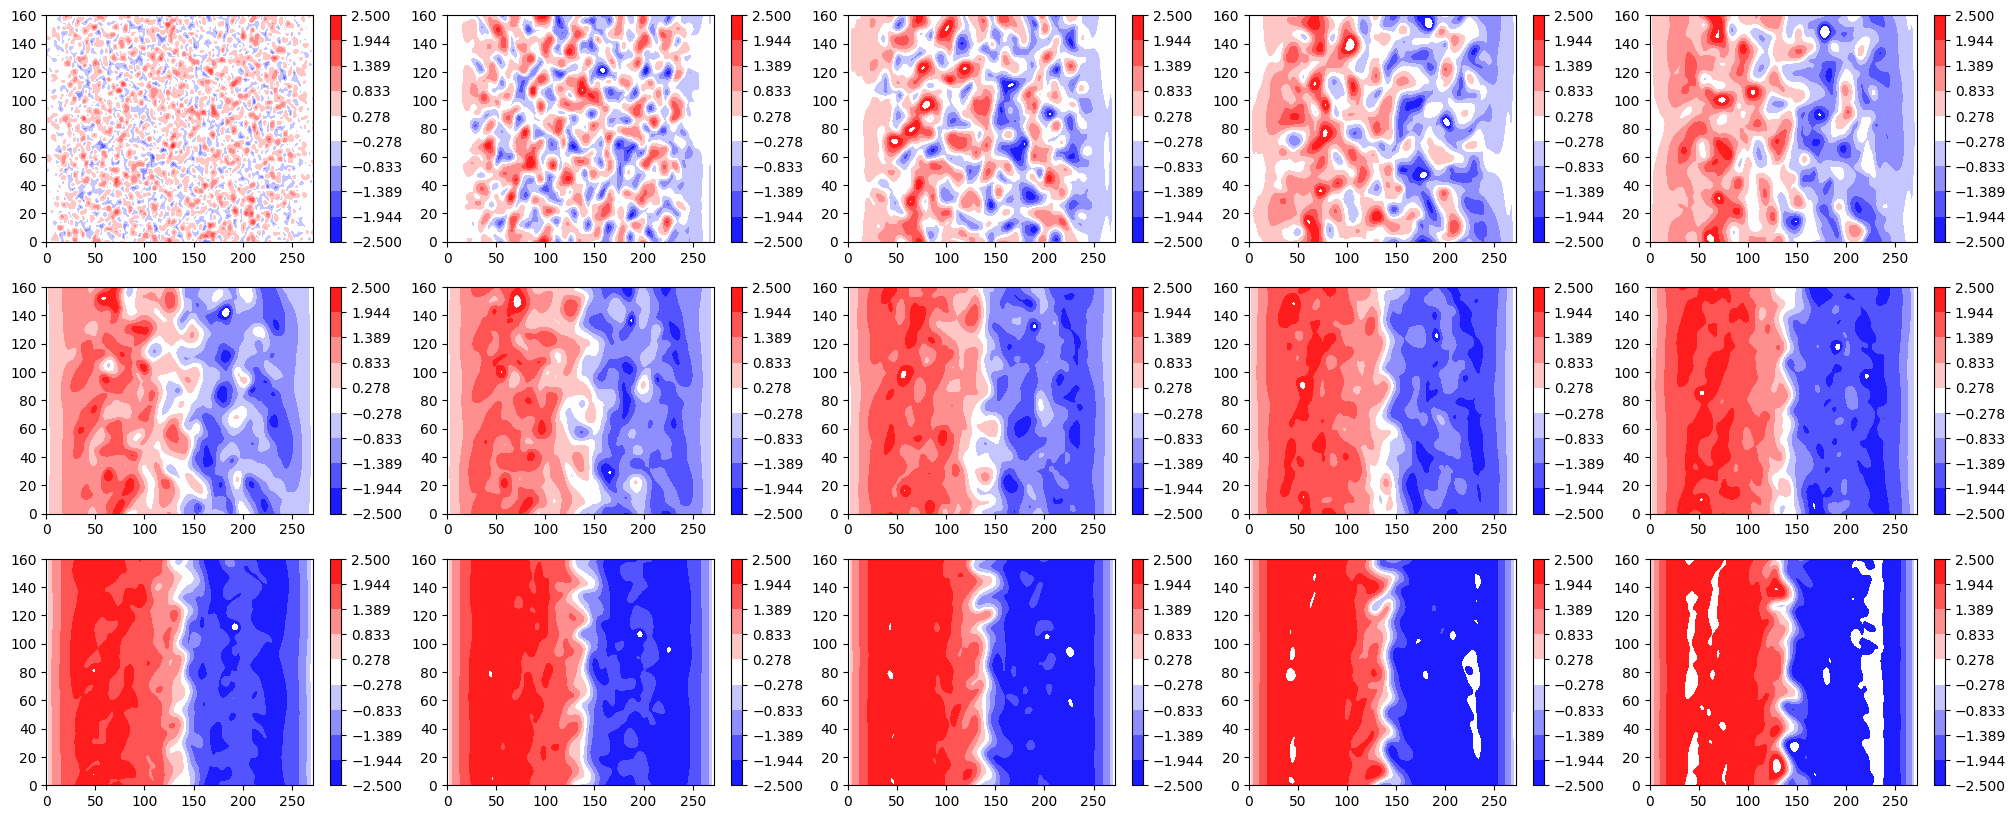

In [115]:
path = "../data/raw"

data = ContiguousSinteticDatasetAutoregressive(path, D = 150)

data = data[0]
data = data[1]['y']

psi1 = data[::2]
psi2 = data[1::2]
# psi1.shape, psi2.shape

fig, axs = plt.subplots(3, 5, figsize = (25, 10))

axs = np.array(axs).flatten()
for i, psi in enumerate(psi2[::len(psi2)//15]):
    plotField2(axs[i], psi, psi.size(-2), psi.size(-1))

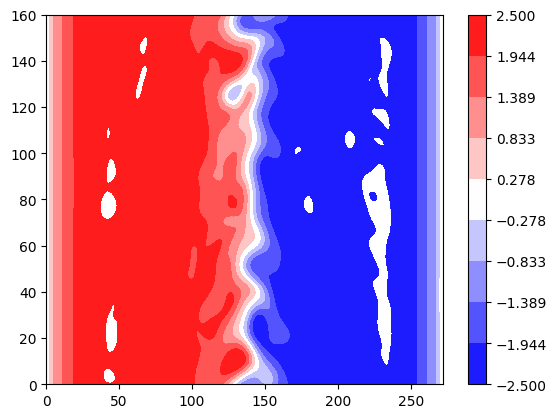

In [122]:
fig, ax = plt.subplots(1, 1)

plotField2(ax, psi2[-30], psi2[-30].size(-2), psi2[-30].size(-1))

In [89]:
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
torch.stack([a , b])[1]

tensor([4, 5, 6])

### Refactor, easier way to plot data

In [10]:
Nx = (40*2)*2
Ny = (68*2)*2

In [37]:
path = "../data/raw"
data = SinteticDataset(path, D = 150)

NameError: name 'SinteticDataset' is not defined

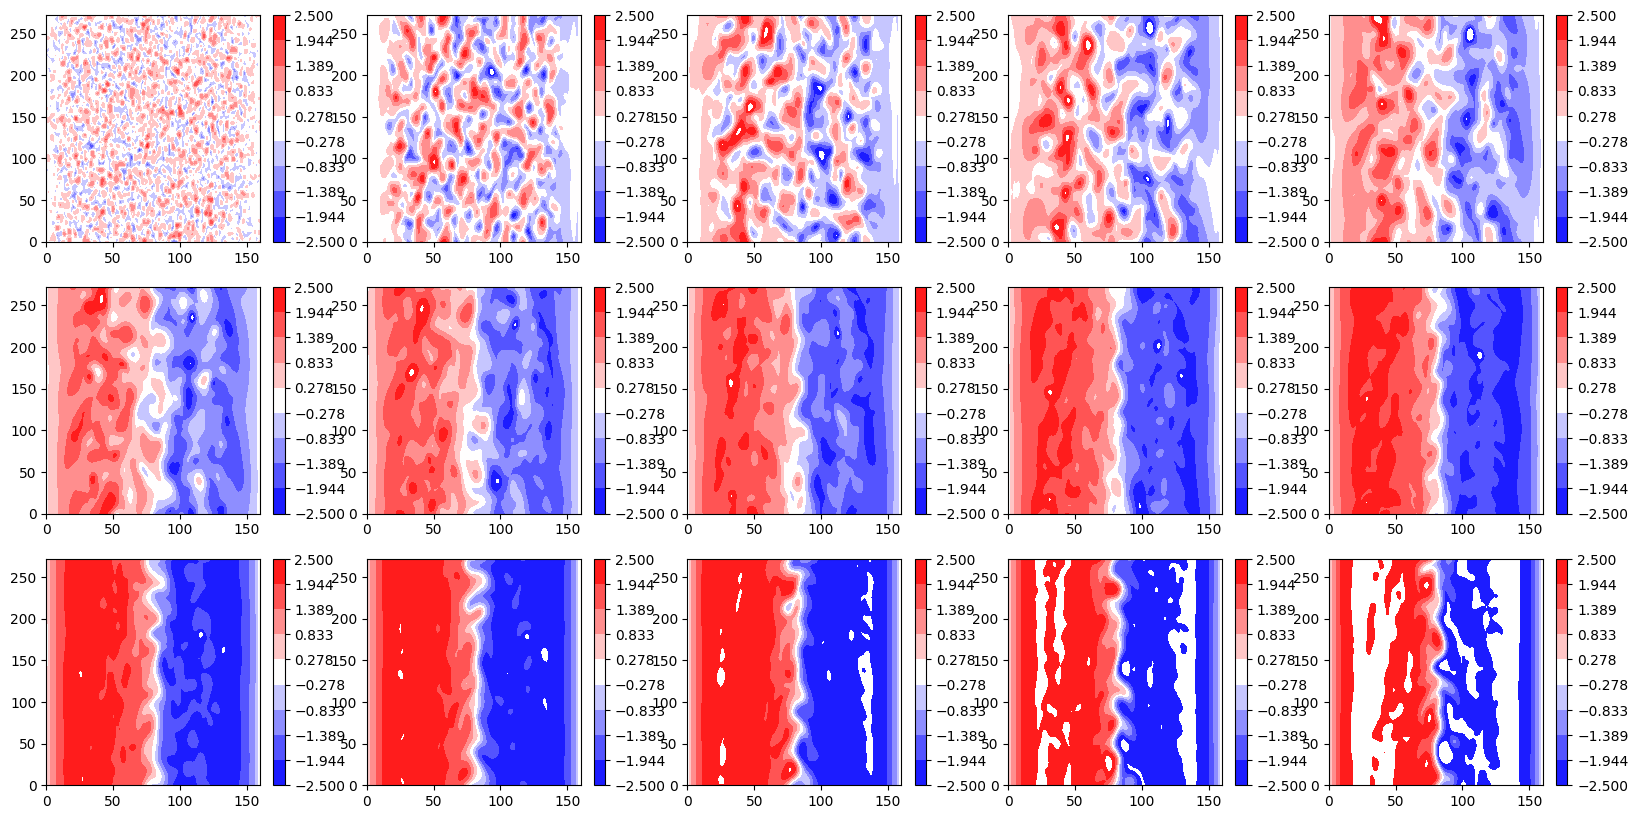

In [102]:
# data[0].shape
# [D, [phi1,phi2], Ny, Nx]
# [150, 2        ,272,160]

fig, axs = plt.subplots(3,5, figsize = (20,10))
ax = np.array(axs).flatten()
# fig.suptitle("first simulation psi2") ??

for i in range(15):
    p = data[0][i * 150//15][1]

    x = np.linspace(0, Nx, p.shape[0])
    y = np.linspace(0, Ny, p.shape[1])
    X, Y = np.meshgrid(x, y)
    levels = np.linspace(-2.5, 2.5, 10)
    # ax[i].set_cmap('bwr')
    contour = ax[i].contourf(X, Y, np.transpose(p), levels=levels, cmap = 'bwr')
    plt.colorbar(contour, ax=ax[i]) #, label='Value')


In [65]:
import torch.nn.functional as F
INPUT_DIM_X = 272
INPUT_DIM_Y = 160
DOWNGRADE_FACTOR = 8

p1 = data[-30][1][0] #First datapoint, phi1
lr_x = F.interpolate(p1.unsqueeze(0).unsqueeze(0), size=(INPUT_DIM_X//DOWNGRADE_FACTOR, INPUT_DIM_Y//DOWNGRADE_FACTOR), mode='bilinear', align_corners=False)
print(lr_x[0][0].shape)
lr_x = F.interpolate(lr_x, size=(INPUT_DIM_X, INPUT_DIM_Y), mode='bilinear', align_corners=False)[0][0]
print(lr_x.shape)

fig, axs = plt.subplots(1,2,figsize = (15,5))

x = np.linspace(0, Nx, p.shape[0])
y = np.linspace(0, Ny, p.shape[1])
X, Y = np.meshgrid(x, y)
levels = np.linspace(-2.5, 2.5, 10)
# ax[i].set_cmap('bwr')
contour = axs[0].contourf(X, Y, np.transpose(lr_x), levels=levels, cmap = 'bwr')
contour = axs[1].contourf(X, Y, np.transpose(p1), levels=levels, cmap = 'bwr')
plt.colorbar(contour, ax=axs) #, label='Value')

IndexError: list index out of range

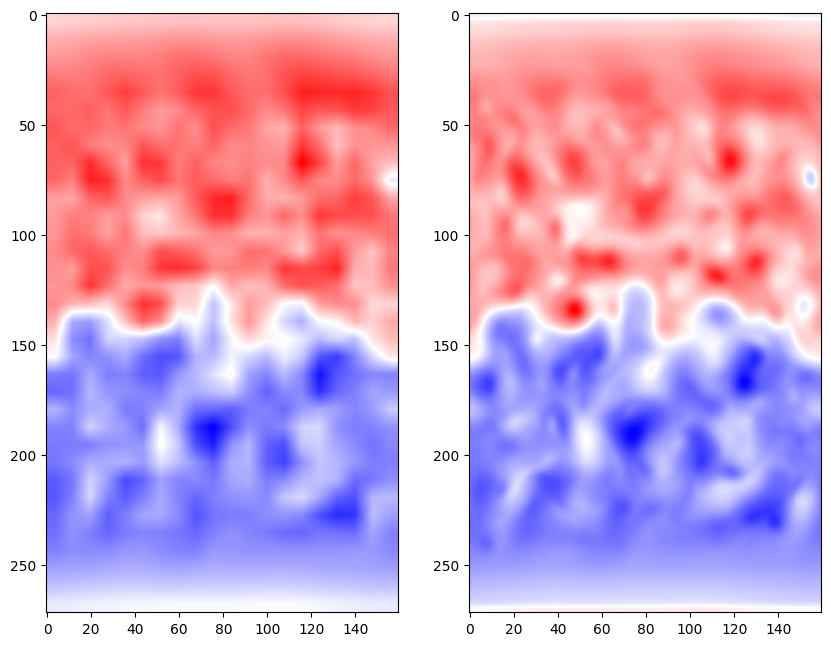

In [57]:
# plt.figure(figsize = (8,14))
fig, axs = plt.subplots(1,2, figsize = (10, 18))
axs[0].imshow(lr_x, cmap = 'bwr')
axs[1].imshow(p1, cmap = 'bwr')

In [27]:
path = "../data/raw/"
dataset = SinteticDataset(path, D = 150)

for i in tqdm(range(20)):
    for j in range(150):
        np.save(f"../data/processed/{i}_psi1_{j}.npy", dataset[i][j][0])
        np.save(f"../data/processed/{i}_psi2_{j}.npy", dataset[i][j][1])


100%|██████████| 20/20 [05:17<00:00, 15.86s/it]


Create gif showing the evolution of the simulation

In [47]:
# fig, axs = plt.subplots(3,5, figsize = (20,10))
# ax = np.array(axs).flatten()
# fig.suptitle("first simulation psi2") ??

# from PIL import Image
path = "../data/raw"
data = SinteticDataset(path, D = 150)

import torch
import numpy as np
from PIL import Image

# Exemplo de um tensor PyTorch (batch de imagens com 3 canais, 256x256)
# Substitua por seus dados de tensor reais

# Função para converter tensor para PIL Image
def tensor_to_pil(tensor):
    # Verificar se o tensor está normalizado (entre -1 e 1), se sim, reverter a normalização
    tensor = tensor.clamp(0, 1)  # Garante que os valores estejam entre 0 e 1
    tensor = tensor.mul(255).byte()  # Converte para intervalo [0, 255] e para tipo byte
    
    if tensor.dim() == 2:
        # Se for um tensor 2D (escala de cinza), não é necessário permutar, basta usar diretamente
        np_image = tensor.cpu().numpy()  # Converte para NumPy array
        return Image.fromarray(np_image, mode='L')  # Cria imagem Pillow em escala de cinza
    elif tensor.dim() == 3:
        # Se for um tensor 3D (RGB), permutar as dimensões
        np_image = tensor.permute(1, 2, 0).cpu().numpy()  # Converte para NumPy (HWC)
        return Image.fromarray(np_image)

def tensor_to_pil_with_colormap(tensor, cmap='bwr'):
    # Garantir que o tensor esteja no intervalo [0, 1]
    tensor = tensor.clamp(0, 1).cpu().numpy()
    
    # Aplicar o colormap do Matplotlib
    colormap = plt.get_cmap(cmap)
    colored_image = colormap(tensor)  # Isso retorna um array RGBA
    
    # Converter para RGB (descarta o canal Alpha)
    rgb_image = (colored_image[:, :, :3] * 255).astype(np.uint8)  # Escala para [0, 255]
    
    # Converter para imagem PIL
    return Image.fromarray(rgb_image)

# Lista para armazenar as imagens convertidas
images = []

# Simulando várias imagens para o GIF
for i in range(150):
    p = data[0][i][1]
    images.append(tensor_to_pil_with_colormap(p))

# Salvar as imagens como um GIF animado
images[0].save('output.gif', save_all=True, append_images=images[1:], duration=100, loop=0)

print("GIF created successfully!")


GIF created successfully!
